In [ ]:
import matplotlib.pyplot as plt
import scipy.io as sio
import random as rnd
import numpy as np

# Carga de datos desde ficheros .mat
datos_mat = sio.loadmat("Clasificador_data.mat")
label_mat = sio.loadmat("Clasificador_label.mat")

# Extracción de los arreglos de datos
datos_raw = datos_mat["data"]
label_raw = label_mat["label"]

# Creación de un dtype de numpy adecuado para almacenar los datos
labeled_dtype = np.dtype([("data", np.float, datos_raw.shape[1]), ("label", 'U1')])

# Unión de datos crudos y etiquetas
datos = np.zeros(datos_raw.shape[0], dtype=labeled_dtype)
for index in range(len(datos)):
    datos[index][0] = datos_raw[index]
    datos[index][1] = label_raw[index][0][0]

# Función auxiliar que separa un subconjunto de datos de dataset dado en dos particiones dadas por su etiqueta de clase B y M
# la primera coodenada es el subconjunto de clase B y la segunda el de clase M
def BM_split(x):
    contador_B = 0
    contador_M = 0
    for dato in x:
        if dato[1] == "B":
            contador_B += 1
        else:
            contador_M += 1
    B_subset = np.zeros(contador_B, dtype=labeled_dtype)
    M_subset = np.zeros(contador_M, dtype=labeled_dtype)
    B_index = 0
    M_index = 0
    for dato in x:
        if dato[1] == "B":
            B_subset[B_index] = dato
            B_index += 1
        else:
            M_subset[M_index] = dato
            M_index += 1
    return B_subset, M_subset
    
# Función que dado un dataset (x), divide el mismo en dos conjuntos, uno de entrenamiento (primera componente del resultado) y
# otro de testing (segunda componente del resultado) según los porcentajes dados para cada cual (parámetros train y testing -
# números entre 0 y 100) respectivamente.
def DataBase(x, train=60, test=40):
    if (type(train) == (float or int)) or (type(float) == (float or int)):
        raise TypeError("Los parámetros train y test deben ser números")
    if train < 0 or test < 0:
        raise ValueError("Los porcentajes deben ser números positivos")
    if train + test > 100:
        raise ValueError("Los porcentajes en conjunto no pueden exceder el 100%")
    # Obtención de subconjuntos de clase B y M
    B_set, M_set = BM_split(x)
    # Obtención de proporciones entre clases
    B_prop  = len(B_set)/len(x)
    M_prop  = len(M_set)/len(x)
    # Cantidad total de datos en subconjuntos de entrenamiento y prueba
    n_train = len(x)*train//100
    n_test  = len(x)*test//100
    # Cantidad de datos de entrenamiento y prueba para cada clase (proporcional, i.e., muestreo estratificado)
    b_train = int(B_prop * n_train)
    b_test  = int(B_prop * n_test)
    m_train = int(M_prop * n_train)
    m_test  = int(M_prop * n_test)
    # Obtención aleatoria de índices a considerar en los subconjuntos resultantes
    B_index_range = rnd.sample(range(len(B_set)), b_train+b_test)
    M_index_range = rnd.sample(range(len(M_set)), m_train+m_test)
    # División de ambas clases en entrenamiento y prueba
    B_train_set = B_set[B_index_range[:b_train]]
    M_train_set = M_set[M_index_range[:m_train]]
    B_test_set  = B_set[B_index_range[b_train:]]
    M_test_set  = M_set[M_index_range[m_train:]]
    # Mezcla de los conjuntos
    train_set = np.concatenate((B_train_set, M_train_set))
    test_set  = np.concatenate((B_test_set, M_test_set))
    # Reordenamiento aleatorio de los conjuntos resultantes a fin de evitar posibles sesgos en tratamiento posterior
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)
    return train_set, test_set

# Función que dado un conjunto de datos de entrenamiento (X) retorna los parámetros del detector, estos son:
# --- Vectores de promedios por atributo para cada clase, estimador insesgado de la media ---
# B_promedio y M_promedio
# --- Vector de desviaciones estandar por atributo para cada clase, estimador insesgado para la raíz de la varianza ---
# B_std y M_std
# --------------------
# La función retorna un par ordenado de pares ordenados de la forma
# (B_promedio, B_std), (M_promedio, M_std)
def Parametros(X):
    B_class, M_class = BM_split(X)
    n_atributos = len(X[0][0])
    B_promedio = np.zeros(n_atributos)
    M_promedio = np.zeros(n_atributos)
    B_std = np.zeros(n_atributos)
    M_std = np.zeros(n_atributos)
    for index_atributo in range(n_atributos):
        valores_atr_enB = np.zeros(len(B_class))
        valores_atr_enM = np.zeros(len(M_class))
        for index_dato in range(len(B_class)):
            valores_atr_enB[index_dato] = B_class[index_dato][0][index_atributo]
        for index_dato in range(len(M_class)):
            valores_atr_enM[index_dato] = M_class[index_dato][0][index_atributo]
        B_promedio[index_atributo] = np.mean(valores_atr_enB)
        M_promedio[index_atributo] = np.mean(valores_atr_enM)
        B_std[index_atributo] = np.std(valores_atr_enB, ddof=1)
        M_std[index_atributo] = np.std(valores_atr_enM, ddof=1)
    return (B_promedio, B_std), (M_promedio, M_std)

# Función que dado los parámetros resultantes de la fase de entrenamiento, es decir, el par ordenado de pares ord. de la forma:
# parametros = ( (B_promedio, B_std) , (M_promedio, M_std) )
# En suma con el conjunto de prueba (test_set) y el umbral de decisión (umbral), retorna un vector con la clase decidida para
# cada observación del conjunto de prueba, cada clase se representa con un entero 1 en caso que se clasifique el paciente con
# cáncer (clase M) o 0 en caso contrario (clase B)
# ----------
# NOTA: el conjunto de prueba ingresado corresponde a los datos sin etiquetar destinados a prueba, es decir solo el campo "data"
# de cada tupla de dtype labeled_dtype, es decir test_set corresponde a DataBase(datos)[1]["data"]
def Detector(parametros, test_set, umbral):
    try:
        B_promedio = parametros[0][0]
        M_promedio = parametros[1][0]
        B_std = parametros[0][1]
        M_std = parametros[1][1]
    except IndexError:
        raise TypeError("Campo parametros debe tener la forma ( (B_promedio, B_std) , (M_promedio, M_std) )")
    resultados = np.zeros(len(test_set))
    for obs_index in range(len(test_set)):
        B_exp = np.exp(sum(-(test_set[obs_index]-B_promedio)**2/(2*B_std**2)))
        M_exp = np.exp(sum(-(test_set[obs_index]-M_promedio)**2/(2*M_std**2)))
        expresion = M_exp/B_exp if B_exp != 0 else np.inf
        resultados[obs_index] = int(expresion > umbral)
    return resultados

# Función que dados dos vectores, uno de la clase vedadera de los datos (clase_real), obtenida desde el campo "label" de los
# datos de prueba (de forma similar análoga a como se obtienen los campos "data" de la función Detector), en conjunto con un
# vector de la clase decidida por el predictor (salida de la función Detector), calcula la tasa de detección (beta) y la
# tasa de falsos positivos (alpha), retornándolas en la tupla de la forma (alpha, beta)
def Performance(clase_real, clase_predicha):
    if len(clase_real) != len(clase_predicha):
        raise IndexError("Los vectores ingresados deben ser del mismo largo")
    M_total = 0
    B_total = 0
    falsos_positivos = 0
    detecciones_correctas = 0
    for i in range(len(clase_real)):
        es_maligno = clase_real[i] == "M"
        es_detectado = bool(clase_predicha[i])
        if es_maligno:
            M_total += 1
            if es_detectado:
                detecciones_correctas += 1
        else:
            B_total += 1
            if es_detectado:
                falsos_positivos += 1
    alpha = falsos_positivos/B_total
    beta  = detecciones_correctas/M_total
    return alpha, beta

# Función que dado un dataset (dataset) con la misma estructura con la cual se ha operado en las funciones anteriores, grafica
# la curva ROC asociada al entrenamiento y test del detector de anomalías, esto lo realiza iterando detecciones (ejecuciones de
# detector) sobre un rango logarítmico que comienza en min_val, termina en max_val y contiene steps pasos.
# ====================
# Adicionalmente el parámetro margen refiere a la adición de un margen adicional al gráfico de modo de visualizar la curva de
# forma adecuada en conjunto con el parámetro significancia, que en caso de no ser nula, muestra en consola el valor umbral, de
# alpha y de beta asociados a la significancia ingresada, y además marca en el gráfico los valores de alpha y beta.
# Finalmente, el parámetro get_info, marca si se desea que se muestre en consola información útil para el cálculo de los costos
# asociados
def PlotROC(dataset, min_val=10**(-20), max_val=10**200, steps=10000, margen=0.05, significancia=None, get_info=False):
    # Configuración de entrenamiento
    train_set, test_set = DataBase(datos, 60, 40)
    params = Parametros(train_set)
    # Configuración del bucle
    min_exp  = np.log(float(min_val))/np.log(10.0)
    max_exp  = np.log(float(max_val))/np.log(10.0)
    umbrales = np.logspace(min_exp,max_exp,steps)
    alphas   = np.zeros(np.size(umbrales))
    betas    = np.zeros(np.size(umbrales))
    
    for index in range(len(umbrales)):
        deteccion = Detector(params, test_set["data"], umbrales[index])
        alphas[index], betas[index] = Performance(test_set["label"], deteccion)
    
    alphas = np.concatenate((np.array([1]), alphas, np.array([0])))
    betas = np.concatenate((np.array([1]), betas, np.array([0])))
    
    if significancia is not None:
        sig_index = None
        for index in range(len(alphas)):
            if alphas[index] <= significancia:
                sig_index = index
                break
    
    plt.plot([0, 0], [0-margen, 1+margen], ls='--', color='grey')
    plt.plot([1, 1], [0-margen, 1+margen], ls='--', color='grey')
    plt.plot([0-margen, 1+margen], [0, 0], ls='--', color='grey')
    plt.plot([0-margen, 1+margen], [1, 1], ls='--', color='grey')
    
    plt.plot([0, 1], [0, 1], color='orange')
    plt.plot(alphas, betas, color='blue')
    plt.plot([0, 1], [0, 1], '.', color='blue')
    
    if significancia is not None:
        if sig_index is not None:
            sig_alpha = alphas[sig_index]
            sig_beta = betas[sig_index]
            plt.plot([sig_alpha, sig_alpha], [0-margen, 1+margen], color='red')
            plt.plot([0-margen, 1+margen], [sig_beta, sig_beta], color='red')
            print("Valor de alpha significativo: {}".format(sig_alpha))
            print("Valor de beta significativo: {}".format(sig_beta))
            print("Valor eta asociado: {}".format(umbrales[index]))
    
    if get_info:
        B_train, M_train = BM_split(train_set)
        B_prob = len(B_train)/len(train_set)
        M_prob = len(M_train)/len(train_set)
        diag_sigma_0 = params[0][1]
        diag_sigma_1 = params[1][1]
        det_sigma_0 = np.prod(diag_sigma_0)
        det_sigma_1 = np.prod(diag_sigma_1)
        print("Probabilidad de la clase B: {}".format(B_prob))
        print("Probabilidad de la clase M: {}".format(M_prob))
        print("Determinante de Sigma_0: {}".format(det_sigma_0))
        print("Determinante de Sigma_1: {}".format(det_sigma_1))

    plt.axis([0-margen, 1+margen, 0-margen, 1+margen])
    plt.xlabel("Nivel de significancia (" +r"$\alpha$" + ")")
    plt.ylabel("Tasa de detección (" +r"$\beta$" + ")")
    plt.title("Curva ROC")

Valor de alpha significativo: 0.04929577464788732
Valor de beta significativo: 0.9642857142857143
Valor eta asociado: 14.659414055105094
Probabilidad de la clase B: 0.6264705882352941
Probabilidad de la clase M: 0.3735294117647059
Determinante de Sigma_0: 1.04243267963763e-08
Determinante de Sigma_1: 3.88420044421048e-09


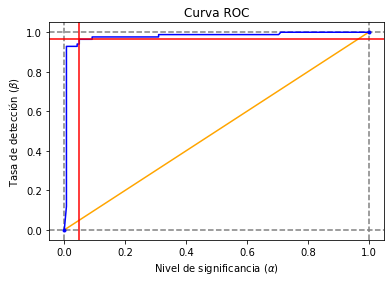

In [ ]:
PlotROC(datos, significancia=0.05, get_info=True)